# Train for review prediction
### Notebook guide:
***This notebook has the following parts***
1. **Loading the data set** :  Load the hotel review dataset
2. **Preprocessing** : using mostly textacy library make lowercase,remove whitespace,replace hashtaggs,phone_numers,urls,emails,remove html_tags punctuation,replace emoji by meaning
3. **select features** : dropping outliers i.e very long text reviews
4. **create train test split** : spliting the data(stratify) for train test eval
5. **dataset class and training code** : create a data loader and load model for training
6. **main training code** : main trainer estimator
6. **load best model and test** : checking f1 score on the test data

### Note: 
Ratings are converted on a the scale of 0 to 4(from the original scale of 1-5), we can say ratings that are less than 2 are negative ratings and anything more than 2 is positive rating, 2 is neutral rating. This conversion is done for bert training.

### References:
1. https://github.com/huggingface/transformers/tree/master/examples/pytorch

# 1. Load the dataset 

In [1]:
import pandas as pd

review_org_data = pd.read_csv('./data/tripadvisor_hotel_reviews.csv')
review_org_dat = review_org_data.dropna().drop_duplicates()
review_org_data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [2]:
review_org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [3]:
review_org_data.describe(include='all')

,Review,Rating
count,20491,20491.000000
unique,20491,NaN
top,nice hotel expensive parking got good deal sta...,NaN
freq,1,NaN
mean,NaN,3.952223
std,NaN,1.233030
min,NaN,1.000000
25%,NaN,3.000000
50%,NaN,4.000000
75%,NaN,5.000000


<AxesSubplot:>

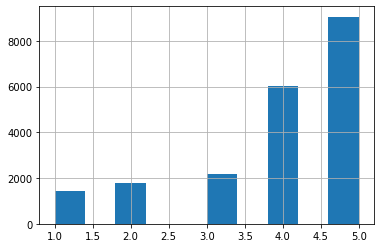

In [4]:
review_org_data['Rating'].hist()

# 2. Preprocessing

In [5]:
import re
import textacy
from textacy import preprocessing
from emoji_translate.emoji_translate import Translator
import nltk

nltk.download('stopwords')

emo = Translator(exact_match_only=False, randomize=True)


def remove_stopword(x):
    return [y for y in x.split(' ') if y not in stopwords.words('english')]


#     return (' ').join([y for y in x.split(' ') if y not in stopwords.words('english')])


def text_preprocessing(text):
    '''
     lowercase,remove whitespace,replace hashtaggs,phone_numers,urls,emails
     remove html_tags punctuation
     replace emoji by meaning
    '''
    text_new = text.lower()
    text_new = re.sub(' +', ' ', text_new)
    text_new = textacy.preprocessing.replace.hashtags(text_new, repl='_HASH_')
    text_new = textacy.preprocessing.replace.phone_numbers(text_new,
                                                           repl='_PHONENUM_')
    text_new = textacy.preprocessing.remove.html_tags(text_new)
    text_new = textacy.preprocessing.replace.urls(text_new, repl='_URL_')
    text_new = textacy.preprocessing.replace.emails(text_new, repl='_EMAIL_')
    text_new = textacy.preprocessing.remove.punctuation(text_new,
                                                        only=[",", ";", ":"])
    text_new = emo.demojify(text_new)
    return text_new

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# TODO: using parallel processing here to make it faster
review_org_data['clean_text'] = review_org_data['Review'].apply(
    lambda x: text_preprocessing(x))

# 3. Selecting features

In [7]:
# converting rating from 0 to 4
review_org_data['rating_from_0'] = review_org_data['Rating'].apply(
    lambda x: x - 1)
# checking text_length of reviews
review_org_data['text_length'] = review_org_data['clean_text'].apply(
    lambda x: len(x.split(" ")))

In [8]:
print('num of reviews having more than 512 words are ', end='')
print(
    len(review_org_data) -
    len(review_org_data[review_org_data['text_length'] < 512]))

num of reviews having more than 512 words are 262


In [9]:
# let's remove them
review_org_data = review_org_data[review_org_data['text_length'] < 512]

In [10]:
# review_org_data[review_org_data['rating_from_0'] == 4].sort_values('text_length',ascending=False)

# 4. Create train test split

In [11]:
from sklearn.model_selection import train_test_split
print('creating train and test split ....')

X = review_org_data['clean_text']
y = review_org_data['rating_from_0']


X_train, X_test, y_train, y_test = train_test_split(
        X, y,stratify=y, test_size=0.2, random_state = 2022)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5,random_state = 2022)

creating train and test split ....


In [12]:
len(X_train),len(X_val),len(X_test)

(16183, 2023, 2023)

In [13]:
from collections import Counter
Counter(list(y_val)),Counter(list(y_test))

(Counter({0: 140, 3: 595, 2: 215, 4: 898, 1: 175}),
 Counter({4: 897, 3: 595, 0: 140, 1: 176, 2: 215}))

In [14]:
import torch
torch.cuda.is_available()

True

# 5. Dataset class, Model Loading 

In [15]:
import transformers as t

In [16]:
model_ckpt = "bert-base-uncased"
tokenizer = t.BertTokenizer.from_pretrained(model_ckpt)
model = t.BertForSequenceClassification.from_pretrained(model_ckpt, num_labels=5).to("cuda")

for name, param in model.bert.named_parameters():
    param.requires_grad = True

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
class Create_Dataset(torch.utils.data.Dataset):

    def __init__(self, reviews, ratings, tokenizer):

        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_len = tokenizer.model_max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = str(self.reviews[index])
        ratings = self.ratings[index]

        encoded_review = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
            padding="max_length",
            truncation=True)

        return {
            'input_ids': encoded_review['input_ids'][0],
            'attention_mask': encoded_review['attention_mask'][0],
            'labels': torch.tensor(ratings, dtype=torch.long)
        }

In [19]:
train_dataset = Create_Dataset(
    reviews=list(X_train),
    ratings=list(y_train),
    tokenizer=tokenizer,
)

validation_dataset = Create_Dataset(
    reviews=list(X_val),
    ratings=list(y_val),
    tokenizer=tokenizer,
)

test_dataset = Create_Dataset(
    reviews=list(X_test),
    ratings=list(y_test),
    tokenizer=tokenizer,
)


In [20]:
len(train_dataset),len(validation_dataset),len(test_dataset)

(16183, 2023, 2023)

In [21]:
# todo add number to token code 

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size  = 16,
    num_workers = 4
)
testing_data = next(iter(test_dataloader))
print( testing_data["input_ids"].size(), testing_data["input_ids"].size() )

torch.Size([16, 512]) torch.Size([16, 512])


In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# todo check this
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 6. Main training code

In [23]:
training_args = t.TrainingArguments(output_dir="./sentiment_analysis",
                                    num_train_epochs=10,
                                    per_device_train_batch_size=8,
                                    per_device_eval_batch_size=8,
                                    warmup_steps=500,
                                    weight_decay=0.01,
                                    evaluation_strategy="epoch",
                                    save_steps=5000)

trainer = t.Trainer(model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=validation_dataset,
                    compute_metrics=compute_metrics)

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.854600,0.878821,0.662383,0.662383,0.662383,0.662383,21.877600,92.469000
2,0.723900,0.765626,0.661394,0.661394,0.661394,0.661394,21.821600,92.706000
3,0.589000,0.822622,0.675729,0.675729,0.675729,0.675729,21.868600,92.507000
4,0.460100,1.104687,0.658922,0.658922,0.658922,0.658922,21.847200,92.598000
5,0.358700,1.566481,0.665348,0.665348,0.665348,0.665348,21.841400,92.622000
6,0.272300,1.877496,0.650519,0.650519,0.650519,0.650519,21.845400,92.605000
7,0.137400,2.097359,0.663371,0.663371,0.663371,0.663371,21.862400,92.533000
8,0.102800,2.441432,0.659417,0.659417,0.659417,0.659417,21.839200,92.632000
9,0.062400,2.572223,0.662383,0.662383,0.662383,0.662383,21.853800,92.570000
10,0.026600,2.744066,0.660405,0.660405,0.660405,0.660405,21.840600,92.626000


TrainOutput(global_step=20230, training_loss=0.3632042271278898, metrics={'train_runtime': 6191.2952, 'train_samples_per_second': 3.267, 'total_flos': 54430104992409600, 'epoch': 10.0})

# 7. Load trained model for testing

In [25]:
model_ckpt = "sentiment_analysis/checkpoint-20000/"
tokenizer = t.BertTokenizer.from_pretrained('bert-base-uncased')
model = t.BertForSequenceClassification.from_pretrained(model_ckpt, num_labels=5).to("cuda")

In [26]:
test_trainer = t.Trainer(model)

In [27]:
final_pred = test_trainer.predict(test_dataset) 

In [28]:
from sklearn.metrics import classification_report
print(classification_report(list(final_pred.label_ids),list(final_pred.predictions.argmax(-1))))

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       140
           1       0.50      0.57      0.53       176
           2       0.47      0.45      0.46       215
           3       0.56      0.58      0.57       595
           4       0.78      0.77      0.78       897

    accuracy                           0.65      2023
   macro avg       0.61      0.60      0.60      2023
weighted avg       0.65      0.65      0.65      2023

